# 1. Purpose & Data

This assignment and the code that follows go through my personal workout data in order to find patterns that are relevant to each of the sports and then being able to classify them accordingly. The data is in a spreadsheet format that was exported from my phone's native health application linked to my sports band that I wear during these workouts.

The various sections that are included in the data are:
- Workout (str) : What type of workout was recorded.
- Duration (int): Time in minutes that the workout was done over.
- Burned(kcal) (int): Number of calories that were burnt during the workout.
- Warmup (int): Time in minutes that was spent during warmup.
- Fat_burn (int): Time in minutes that was spent during fat burning.
- Endurance (int): Time in minutes that was spent during endurance.
- Anareboic (int): Time in minutes that was spent during anaerobic respiration.
- Threshold (Boolean): 1 if heart rate crossed 190 beats per minute during the workout, 0 otherwise.
- Max_heartrate (int): The maximum heart rate reached during the workout.
- Avg_heartrate (int): The average heart rate during the workout.

Warmup, fat burn, endurance, and anaerobic are the four categories that the workout is distributed into based on my heart rate and burning of calories. How exactly this distribution works is not available in public data that could be found on Oneplus's official website.

This pipeline is the third iteration with extensions to the previous two. More details in the section on the models.

Note: Oneplus is the name of the brand that both my phone and my sports band belong to.

# 2. Importing the Data

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# importing sklearn libraries
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# importing packages from keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.layers import Input, Dense
from keras.models import Model

# importing xgboost
import xgboost as xgb
from xgboost import XGBClassifier

# tensorflow.keras packages
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [2]:
data = pd.read_csv('data.csv')
data.head()

,Workout,Duration,Burned(kcal),warmup,fat_burn,endurance,anaerobic,threshold,max_heartrate,avg_heartrate
0,Squash,79,754,12,21,33,13,0,178,144
1,Basketball,62,653,4,19,31,8,0,165,139
2,Basketball,59,648,3,17,29,10,0,168,142
3,Squash,91,972,14,22,42,13,1,197,157
4,Squash,98,1031,13,18,52,15,1,203,161


# 3. Cleaning & pre-processing data

The workout types are in text format that can be converted to numeric values so that the models can easily work with that. We will convert using the map function as shown below:

In [3]:
"""
0 - Squash
1 - Basketball
2 - Volleyball
3 - Walk
4 - Gym
"""
# making a copy of the data to not affect the original data

df = data.copy()

mapper = {'Squash': 0, 'Basketball':1, 'Volleyball':2, 'Walk':3, 'Gym':4}
df['Workout'] = df['Workout'].map(mapper)
df.head()

,Workout,Duration,Burned(kcal),warmup,fat_burn,endurance,anaerobic,threshold,max_heartrate,avg_heartrate
0,0,79,754,12,21,33,13,0,178,144
1,1,62,653,4,19,31,8,0,165,139
2,1,59,648,3,17,29,10,0,168,142
3,0,91,972,14,22,42,13,1,197,157
4,0,98,1031,13,18,52,15,1,203,161


### Descriptive stats

It is important to understand the data and its distributions before we start working with it. The following code gives us the descriptive statistics of the data.

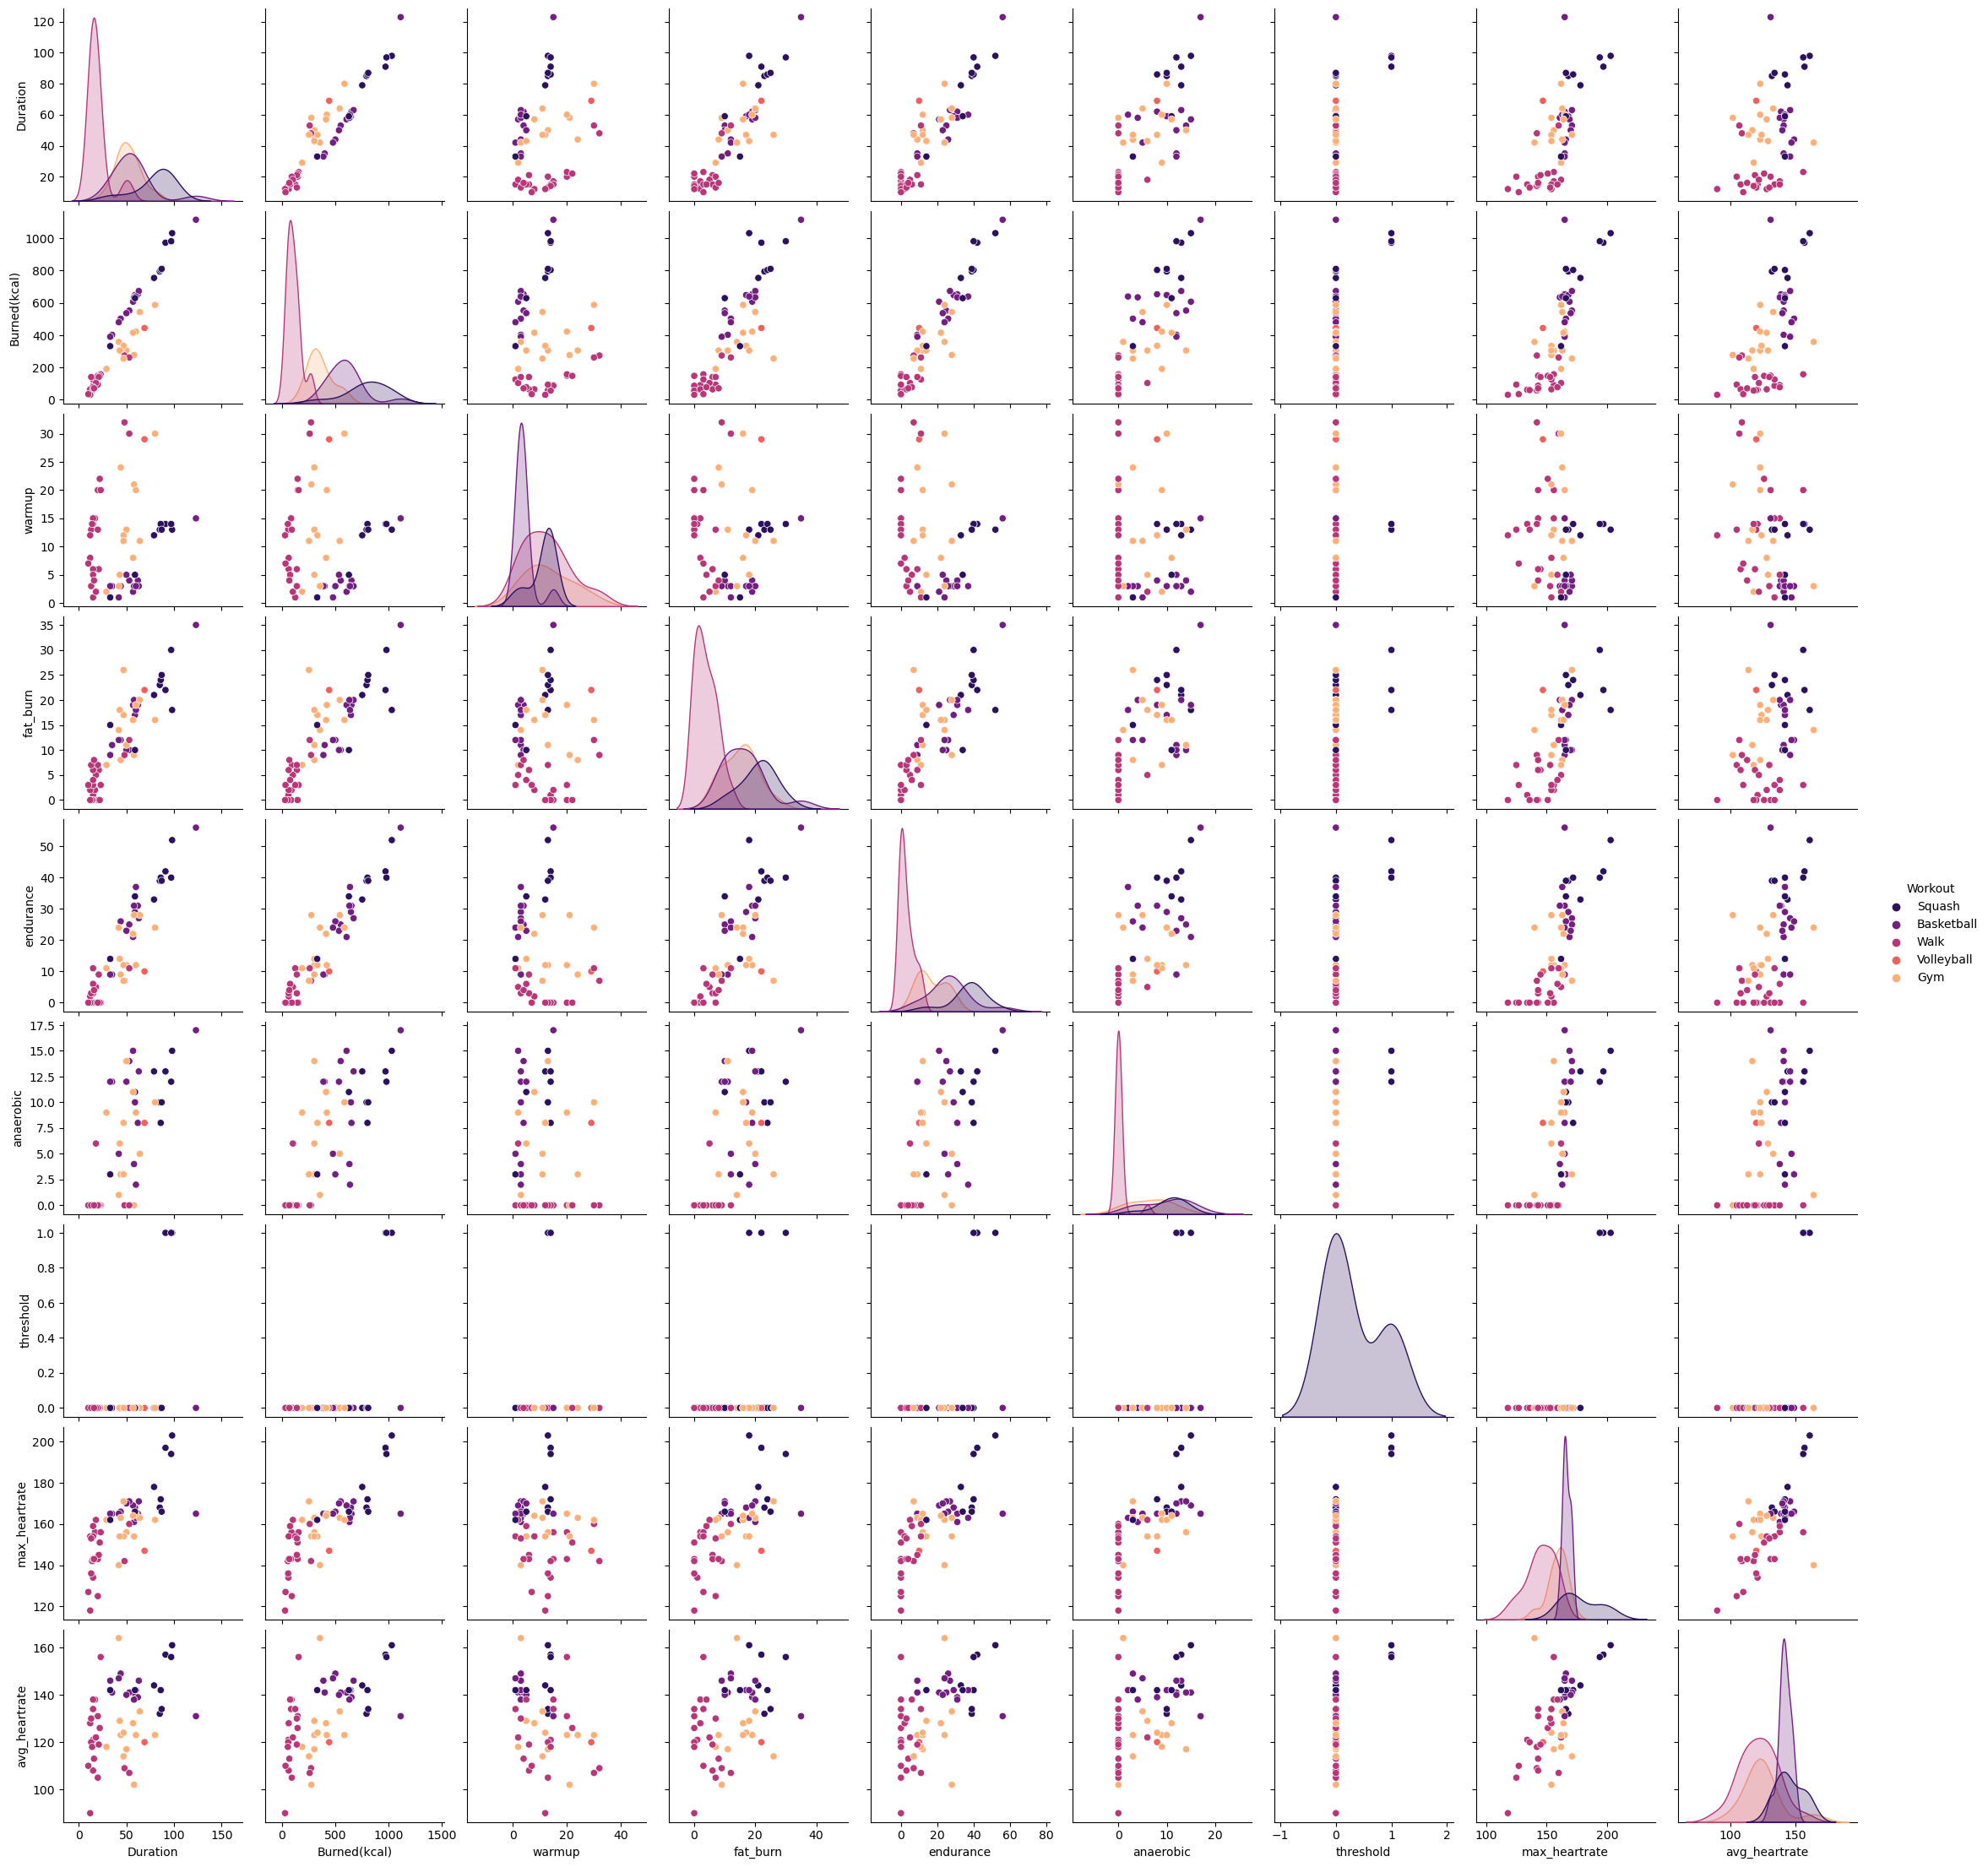

In [4]:
sns.pairplot(data, hue='Workout', palette="magma", kind="scatter")

Looking at the plots above we can see that there are definitely patterns in the data that a model can use to perform classification accordingly. Some interesting patterns that are visually clear are between duration and number of calories burnt. Moreover, duration also seems to be correlated with both fat burn and endurance. However, these patterns are not seen in anaerobic and warmup despite them being categories of respiration as well.

We can also visualize these correlations using a correlation matrix. See below.

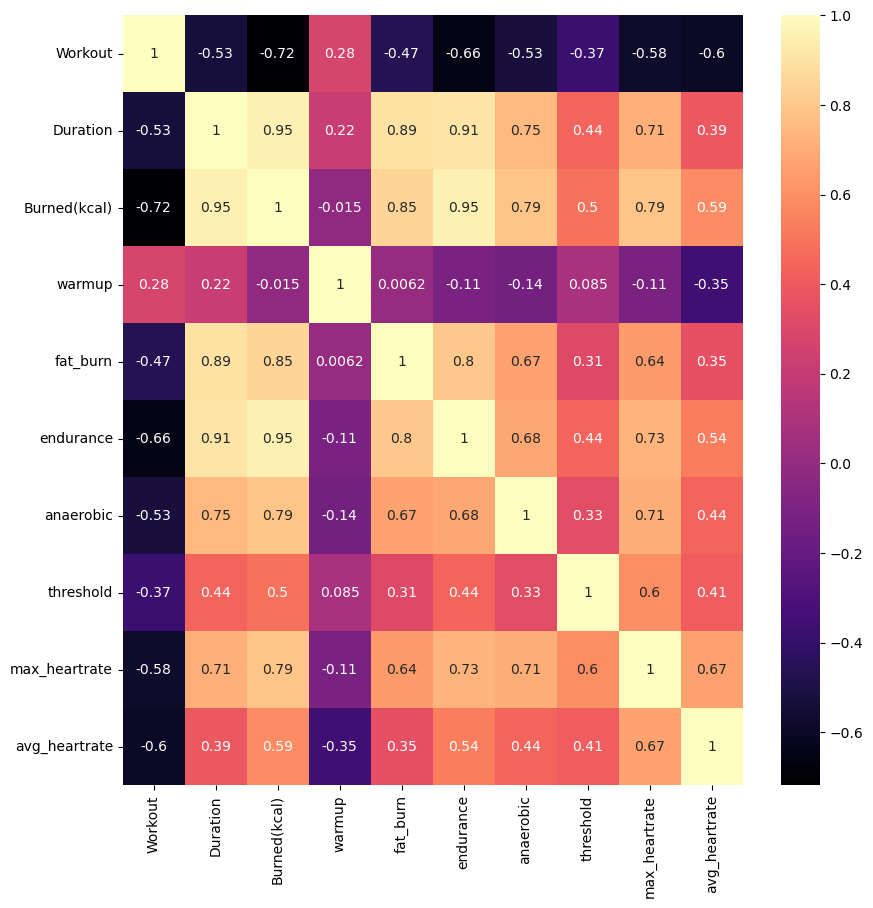

In [5]:
# Plot the correlation matrix
corr = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap="magma")
plt.show()

Next, let's visualize some of the occurence frequencies within the data to see how much data for each type of workout will the model have.

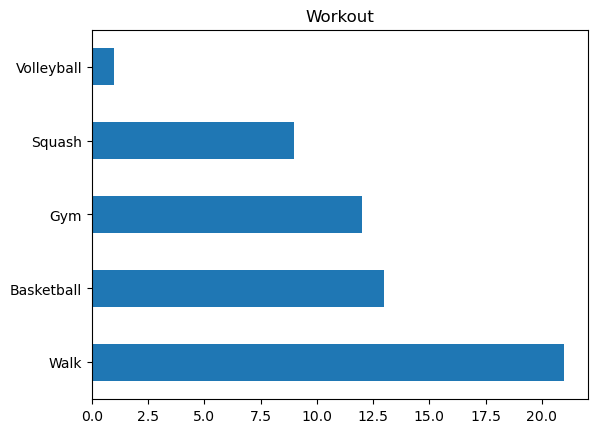

In [6]:
plt.figure()
data['Workout'].value_counts().plot(kind='barh', title='Workout')
plt.show()

It seems that the model does have plenty of data for all the various workouts except for volleyball since that was a rare activity. Thus, any model should be able to learn patterns in the sports and be able to classify them to the respective categories.

General descriptive statistics are printed in the table below but they are not relevant to the discussion for now so I will not go into detail about them.

In [7]:
data.describe()

,Duration,Burned(kcal),warmup,fat_burn,endurance,anaerobic,threshold,max_heartrate,avg_heartrate
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,45.553571,392.428571,10.750000,12.160714,17.053571,5.625000,0.053571,158.410714,130.857143
std,27.338896,291.677584,8.235731,8.597625,15.090538,5.528644,0.227208,15.941686,15.709208
min,10.000000,31.000000,1.000000,0.000000,0.000000,0.000000,0.000000,118.000000,90.000000
25%,19.500000,137.250000,3.000000,5.750000,3.750000,0.000000,0.000000,150.000000,120.000000
50%,45.500000,333.000000,11.000000,11.000000,12.000000,4.500000,0.000000,162.000000,131.500000
75%,60.000000,612.500000,14.000000,19.000000,28.000000,10.250000,0.000000,166.000000,142.000000
max,123.000000,1114.000000,32.000000,35.000000,56.000000,17.000000,1.000000,203.000000,164.000000


# 4. Task and splitting the data

For this pipeline, the main focus is building the best classification model for the data. The purpose is to be able to classify the sports into the correct categories.

Such classification models are in high demand nowadays as most people forget to manually start their workouts and as such data is not recorded despite wearing sports watches. A classification model that can learn the patterns that are present in all these sports could be added as a feature to these sports watches so that it can auto-detect workouts and perhaps alert the wearer to start the workout once it is sure that it is in-progress e.g. I start playing squash but forget to start the workout on my watch. Such models would enable my band to alert me that I should start squash as a workout and then use the data to keep the data-tracking consistent.

The data has to be split into three categories: training, validation and testing. This is the general best practice in the domain of Machine Learning. Not using validation sets might lead to false estimates of confidence in the model accuracy and other metrics. The training data is the part which we feed to our model from which the learning of patterns is done. Once the model learns, we use the validation sets to understand the model's performance across different model types and hyperparameter tuning.

Splitting the data in this case is a hard task. General guidelines indicate that 80% training data, 10% validation data, and 10% testing data is a good split (Baheti, 2023). However, since our data is limited, 10% might not be enough. Since classification models usually include 2-3 parameters, my personal opinion is to use 60% as training data, 20% as validation and 20% for testing data.

One important concern with smaller data is that it might be much harder to generalize models to unseen data especially the ones which require big data such as CNNs or RNNs. More on this later. 

The training dataset is supposed to be as representative as possible along with being unbiased. Thus, the split needs to be randomized as well and can't be hand-picked. The validation set acts as an independent, unbiased dataset for comparing performances. The test set should never be used before the final predictions by the final optimal model because looking at metrics on the test case beforehand is a type of overfitting leading to unreliable performance on unseen data.

However, before we split the data, we will standardize the data. Since some values in the dataset are qute large, we will use the standard scaler to scale the data to have a mean of 0 and a standard deviation of 1. This will help the model to converge faster and also prevent any bias towards the larger values. This should also help to make sure that the feature importance is actually representative of workout characteristics and not just the fact that some features have larger values such as duration.

In [8]:
# defining the outcome and the features of the model
y = df['Workout'].values
X = df.drop(['Workout'], axis = 1).values

# scaling the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# splitting the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=33)
# splitting the test set from above into validation and test sets.
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=33)

# 5. Model Explaining and Training

### Classification Models
Classification models are used in Machine Learning to predict the class or category of a new input data point based on its features. Inputs for classification models are a set of values for certain features (predictors, independent variables etc.) and they output a class label (the target variable) based on the relationship between the features and the class labels observed in the training data. Classification models have many uses in the real world. They are used in spam detection, medical diagnosis, credit card fraud detection, and many more. The most common classification models are logistic regression, decision trees, random forests, and support vector machines. In this pipeline, I will be using random forests, K-nearest neighbors, and support vector machines.

#### Model 1: Random Forest
Random forests use a collection of decision trees to make more accurate predictions than a single decision tree. A decision tree is binary tree structure where each node is a feature and each leaf is a class label. The decision tree is built by splitting the data into two parts based on the feature value. The splitting is done in a way that the information gain is maximized. The information gain is the difference between the entropy of the parent node and the weighted sum of the entropy of the child nodes. The entropy is the measure of the impurity of the data. The main idea is to maximize information gain by minimizing impurity in the leaves.  
Random forests use multiple decision trees to make predictions. The algorithm is as follows:
1. Randomly select a subset of the training data.
2. Randomly select a subset of the features.
3. Build a decision tree using the subset of the data and features.
4. Repeat steps 1-3 for a number of times.
5. Aggregate the predictions of the decision trees to make the final prediction.
  
The key idea behind random forests is that by averaging the predictions of multiple decision trees, the noise and the biases of each individual tree are reduced finding the sweet balance between bias and variance. This leads to more **accurate** and **stable** predictions. Not only are they more robust and accurate, they also provide a measure of feature importance which can be used to understand which features are more important for the model to make predictions. This is useful for feature selection and feature engineering. They are also more suited for handling large datasets and high-dimensional data.  
Random forests use the idea of bagging (bootstrap aggregation) and feature sampling to construct a collection of trees (the forest) and then make them work together to improve prediction accuracy.  
The main mathematics behind random forests is the following:
For each tree, the split is done by selecting predictor $X_j$ and the cut point, s to split the data into two regions, such that we satisfy the following equations: $R_1(j, s) = {X | X_j < s}$ & $R_2(j, s) = {X | X_j \geq s}$.  
The splits seek to minimize: $\sum_{i : x_i \in R_1(j, s)} (y_i - \hat{y}_{R_1})^2 + \sum_{i : x_i \in R_2(j, s)} (y_i - \hat{y}_{R_2})^2$  
where $\hat{y}_{R_1}$ and $\hat{y}_{R_2}$ are the average response values for the observations in the two regions.  
The entropy is calculated using: $\sum_{i=1}^{C} -f_i log(f_i)$; where $f_i$ is the frequency of label i at a dnode and C is the number of unique labels.  
The Gini impurity is calculated using: $\sum_{i=1}^{C} f_i (1 - f_i)$.  
Finally, since the idea is to maximize the information gain, this is done through: $Gain(T, X) = Entropy(T) - Entropy(T, X)$; where T is the target variable, X is the feature to be split on, and Entropy(T, X) is the entropy calculated after the data is split on feature X. (Ronaghan, 2019)  
**Pseduo algorithm**  
Input:  
- Training data $D = \{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)\}$,
- Number of trees $B$,
- number of features to be used for each tree $m$  

Output:
- Trained random forest model

1. For each tree:
    1. Randomly select a subset of the training data.
    2. Construct a decision tree using the following
        - Each node tests a random subset of the features
        - Split the node using the feature that maximizes the information gain
        - Stop splitting when the maximum depth is reached or when the minimum number of samples in a node is reached
    3. Add decision tree to the forest.
2. Return the trained random forest model.

#### Model 2: K-Nearest Neighbors
K-Nearest Neighbors is a simple algorithm that stores all available cases and classifies new cases based on a similarity measure. The similarity measure is the distance between the new case and the stored cases. The new case is classified by a majority vote of its k nearest neighbors, with the case being assigned to the class most common among its k nearest neighbors.  
The distance metric generally used is the Euclidean distance. The Euclidean distance between two points is the length of the line segment connecting them. However, other metrics e.g. Manhattan distance, Minkowski distance, etc. can also be used.
K-NN has several advantages. It is simple to implement, it is versatile, it is non-parametric, it is robust to noisy training data, and it is effective if the training data is large. It is also able to handle non-linear relationships between the features and the target variable.  
However, it has several disadvantages as well. It is computationally expensive, it is sensitive to irrelevant features, and it is sensitive to the scale of the data. The choice of k is also important and can have a significant impact on the performance of the model.  
In practice, K-NN is used as a baseline algorithm to compare the performance of other more complex algorithms. It is also used when the data is relatively small and decision boundary is highly non-linear. It is also used when the data is high-dimensional. Such a model is also quick to update because it just stores the new training data in the model and does not require retraining. However, it does have O(n) space complexity because it stores all the training data.

**Pseduo algorithm**

Input:
- Training data with labels
- Test data points
- Number of nearest neighbors to consider (k)

Output:
- Predicted class labels for the test data points

1. For each test data point:
   - Calculate the distance between the test data point and each training data point using a distance metric (e.g. Euclidean distance)
2. Select the k training data points with the smallest distances to the test data point
3. Assign the test data point to the majority class label among the k-nearest neighbors
4. Repeat steps 1-3 for all test data points
5. Return the predicted class labels for the test data points


### Model 3: Support Vector Machines
Support Vector Machines are a set of supervised learning methods used for classification, regression and outliers detection. The goal of SVM is to find a hyperplane in an N-dimensional space (N is the number of features) that distinctly classifies the data points.  
The hyperplane is chosen such that the distance between the hyperplane and the nearest data points of any class is maximized. The data points that are closest to the hyperplane are called support vectors. The hyperplane is chosen such that the margin between the two classes is maximized. The margin is the distance between the hyperplane and the support vectors.  
SVMs can be used for linearly separable data as well as non-linearly separable data. For non-linearly separable data, the kernel trick is used. The kernel trick is a method of mapping data into a higher dimensional space so that the data becomes linearly separable. The kernel function is a function that takes two inputs and returns a scalar by calculating a dot product. The most common kernel functions are the linear, polynomial, and radial basis function (RBF) kernels.  
SVMS have several advantages. They have high accuracy on both linearly separable (a linear line can separate the classes). SVMs are robust as they are less sensitive to outliers as compared to other algorithms. They can handle a large range of feature spaces, including high dimensional data which makes them flexible.  
The limitations of SVMs include scalability because they are computationally expensive for large datasets and retraining. Choosing the appropriate kernel and tuning the hyperparameters is also a challenge.  
Interpretability of SVMs is a topic of debate. In some cases where the boundary is low dimensional, they are easy to interpret but high-dimensional boundary can be difficult to interpret.

**Pseduo algorithm**

Input:
- Training data with labels
- Test data points
- Regularization parameter (C)
- Kernel function (e.g. linear, polynomial, radial basis function)

Output:
- Predicted class labels for the test data points

1. Construct the kernel matrix K for the training data points using the kernel function:  
    $K(i, j) = kernel_function(x_i, x_j)$, where $x_i$ and $x_j$ are training data points
   
2. Solve the following quadratic optimization problem to obtain the optimal hyperplane:
   $minimize (1/2) * \alpha^T * K * \alpha - sum(\alpha)$  
   subject to:
      - y^T * \alpha = 0
      - 0 <= \alpha <= C  
   where $\alpha$ is a vector of Lagrange multipliers, y is a vector of class labels, and C is the regularization parameter
3. Calculate the bias term b as:
   $b = 1/n_sv * sum(y_k - sum(\alpha_i * y_i * kernel_function(x_i, x_k)))$, 
   where $k$ is a support vector and $n_sv$ is the number of support vectors

4. For each test data point:
   1. Calculate the decision function as:
        $f(x) = sum(\alpha_i * y_i * kernel_function(x_i, x_j)) + b$
   2. Assign the test data point to the class with the highest decision function value
5. Repeat step 4 for all test data points
6. Return the predicted class labels for the test data points

In [9]:
# Training KNN, SVM, and Random Forest models

# defining the models.
# For KNN: p=2 is for Euclidean distance. Default, neighbors = 5
# For SVM: default kernel = rbf, C = 1, gamma = scale (1/n_features)
# For RF: default n_estimators = 100, max_depth = None (no limit), max_features = sqrt(n_features)
models = {'KNN': KNeighborsClassifier(p=2),
          'SVM': SVC(),
          'Random Forest': RandomForestClassifier()}
# we iterate over all the models, fit the training data and then check metric against validation set
for name, model in models.items():
    model.fit(X_train, y_train)
    test_score = model.score(X_val, y_val)
    print(f'{name} validation accuracy: {test_score:.3f}')
# store the validation accuracies of the models
val_acc_pre = [model.score(X_val, y_val) for model in models.values()]

KNN validation accuracy: 0.818
SVM validation accuracy: 0.909
Random Forest validation accuracy: 0.909


### Model 4: XGBoost
XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. It is an ensemble method that combines multiple decision trees in order to improve the predictive accuracy and control over-fitting. It is used widely for regression, classification, and ranking problems. At a high level, XGBoost can be seen as an ensemble of decision trees, where each new tree is fit on the residual errors of the previous trees in the ensemble.  
The mathematical explanation is based on the fact that it optimizes a loss function through a process called gradient boosting. The model is built iteratively and each tree is built on the residuals of the previous tree. The loss function is minimized by adding new trees to the model. This is done through gradient descent where the model is updated by adding a new tree that is a weighted combination of the previous trees. We shall get more into the maths later on.  
XGBoost combines the strengths of two ML algorithms: decision trees and gradient boosting. Decision trees are used to model non-linear relationships and gradient boosting is used to reduce the bias. Decision trees are also intutive and easy to understand & interpret despite their ability to model complex relationships. Gradient boosting reduces the bias in the model by combining weak models into a stronger model. XGBoost combines these techniques enabling it to handle large datasets with millions of features and samples.  
The main advantages of XGBoost are:  
- Speed and performance: XGBoost is highly optimized for speed and performance, making it one of the fastest and most accurate gradient boosting libraries available. It is designed to handle large datasets and can be easily parallelized across multiple CPU cores and clusters.
- Accuracy: XGBoost is known for its high accuracy and low error rates, especially in complex and nonlinear data modeling tasks. It uses a combination of regularization, sparsity, and parallel processing techniques to improve model accuracy and reduce overfitting.
- Flexibility: XGBoost is highly flexible and customizable, with a wide range of hyperparameters and tuning options that can be adjusted to optimize model performance for specific use cases and datasets.
- Interpretability: XGBoost provides a range of tools and techniques for interpreting and visualizing model outputs, including feature importance scores, decision trees, and partial dependence plots.  

**Mathematics**
XGBoost can be represented by the following equation:  
$y = f(x) = w_0 + w_1*h_1(x) + w_2*h_2(x) + ... + w_n*h_n(x)$
where y is the target variable, x is the feature vector, w is the weight vector, and h is a representation of the trees. The most commonly used loss function for XGBoost is:  
$L(y, f(x)) = \sum_{i}[l(y_i, f_i(x_i)) + \Omega(f)]$  
where L is the loss function, y is the target variable, f(x) is the prediction, $l$ is the loss function for a single data point, and $\Omega$ is the regularization term to prevent overfitting, with i representing the various data points.  
This loss function is optimized using gradient boosting which involves iteratively adding trees to the ensemble with the new tree fitting to the residuals of the previous tree & then being added to the whole model as a weighted combination of the previous trees. The residuals are defined as:  
$r_i = y_i - f_{i-1}(x_i)$  
where r is the residual, y is the target variable, f is the prediction, and i is the data point. The new decision tree is trained to predict these residuals rather than the actual target variable. The new tree is then added to the model using:  
$f_i(x) = f_{i-1}(x) + \eta h_i(x)$  
where f is the prediction, $h_i(x_i)$ is the prediction of the new decision tree for the ith data point, and $\eta$ is the learning rate which controls the contribution of each tree to the final model. This addition process continues until a stopping criterion is met e.g. maximum number of iterations or minimum loss reduction.

**Pseduo algorithm**

Input:
- Training data with labels
- Test data points
- Number of trees (n_estimators)
- Maximum depth of trees (max_depth)
- Learning rate (eta)
- Regularization parameters (lambda and alpha)

Output:
- Predicted class labels for the test data points

1. Initialize a base prediction as the average label value of the training data
2. For each tree in the ensemble:
   1. Calculate the gradient and the hessian for each training data point:
      - Gradient = - (partial loss / partial prediction)
      - Hessian = (partial^2 loss / partial prediction^2)
   2. Fit a regression tree to the gradient and hessian values with the following hyperparameters:
      - max_depth = max_depth
      - lambda = lambda
      - alpha = alpha
   3. Calculate the predicted values for each training data point using the regression tree
   4. Update the base prediction by adding the predicted values multiplied by a learning rate (eta)
3. For each test data point:
   1. Pass the test data point through each tree in the ensemble and calculate the predicted value
   2. Assign the test data point to the class with the highest predicted value
4. Repeat step 3 for all test data points
5. Return the predicted class labels for the test data points

In [10]:
# Training XG Boost

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# specify parameters via map
param = {'max_depth':2, 'eta':1, 'objective':'multi:softmax', 'num_class':5}

bst = xgb.train(param, dtrain, 100)

# make prediction
preds = bst.predict(dval)
xgb_accuracy_pre = metrics.accuracy_score(y_val, preds)
print(f'XGBoost validation accuracy: {xgb_accuracy_pre:.3f}')

XGBoost validation accuracy: 0.909


### Model 5: Convolutional Neural Networks
Convolutional Neural Networks (CNNs) are a type of neural network that are used for image classification and recognition. They are a type of feed-forward neural network. They are composed of an input and an output layer, as well as multiple hidden layers. The hidden layers of a CNN typically consist of convolutional layers, pooling layers, and fully connected layers.  
They can be thought of as a neural network with many identical copies of the same neuron allowing the network to have a lot of neurons with the ability to express computationally large models while keeping the number of parameters to be fairly small. The main idea is to use a group of neurons that at various inputs rather than just one like a "fully-connected network" and then uses that to extract features. The output one is fed into the next layer allowing for detection of higher-level, more abstract features. CNNs are interweaved with pooling layers which are used to reduce the dimensionality of the output from the convolutional layers. Max pooling is the most common type of pooling layer which is like "zooming-out" and telling whether a feature was present or not. It doesn't tell us where the feature was present. Max-pooling also makes us invariant to very small transformations of data. CNNs are feed-forward neural networks.  
The main advantages of CNNs are:
- They are able to learn spatial invariance. This means that they can recognize the same object even if it is in a different position or orientation. This is because the weights are shared across the entire image.
- They are able to learn feature hierarchies. This means that they can learn low-level features such as edges and corners and then combine them to form higher-level features such as shapes and textures.
- They are able to share the parameters since they apply the same filter to the entire input which reduces the number of parameters that need to be learned.

However, CNNs have some limitations:
- CNNs require large datasets to work which is time-consuming and expensive to collect.
- CNNs can easily overfit the training data if the dataset is too small. Regularization techniques such as dropout can be used to reduce overfitting.
- CNNs are not very interpretable. They are black-box models and it is difficult to understand how they make their predictions.  

**Mathematics**  
Mathematically explaining CNNs is quite hard as they are considered to be black-box models. The easiest way to understand CNNs is by thinking of each filter in the CNN layer as a small matrix of weights that is convolved with the input data to produce a feature map. The feature map is then passed to the next layer which reduce the dimensions while retaining the most important features.  
The output of the pooling layers is flattened and then passed to the fully connected layers which are used for classification.  
Given an input data matrix X of size (n, m, p), and a filter matrix, F of size (k, k, p), the convolution operation produces an output matrix of size (n-k+1, m-k+1, 1) where:  
$Y(i, j) = sum(X[i:i+k, j:j+k]* F)$ where sum represents the sum over all the elements in the resulting matrix.  
The output of the fully connected final layer can be expressed as:  
$Y = W*X + b$ where Y is the output, W is the weight matrix, X is the input, and b is the bias.

**Pseduo algorithm**

Input:
- Training data (X_train) with corresponding labels (y_train)
- Validation data (X_val) with corresponding labels (y_val)
- Number of epochs to train (epochs)
- Batch size for training (batch_size)

Output:
- Trained CNN model

1. Prepare the data:
   1. Reshape the training and validation data to the desired input shape
   2. One-hot encode the training and validation labels
2. Define the CNN architecture:
   1. Create a Sequential model
   2. Add convolutional layers with the desired number of filters, kernel size, activation function, and input shape
   3. Add pooling layers with the desired pool size
   4. Flatten the output of the convolutional layers
   5. Add fully connected layers with the desired number of neurons and activation function
   6. Add an output layer with the number of classes and softmax activation
3. Compile the model:
   1. Specify the loss function (e.g. categorical cross-entropy)
   2. Specify the optimizer (e.g. Adam)
   3. Specify evaluation metrics (e.g. accuracy)
4. Train the model:
   1. Fit the model to the training data with the desired number of epochs and batch size
   2. Validate the model on the validation data
5. Evaluate the model:
   1. Evaluate the model on the test data
   2. Generate predictions for new data
6. Return the trained CNN model

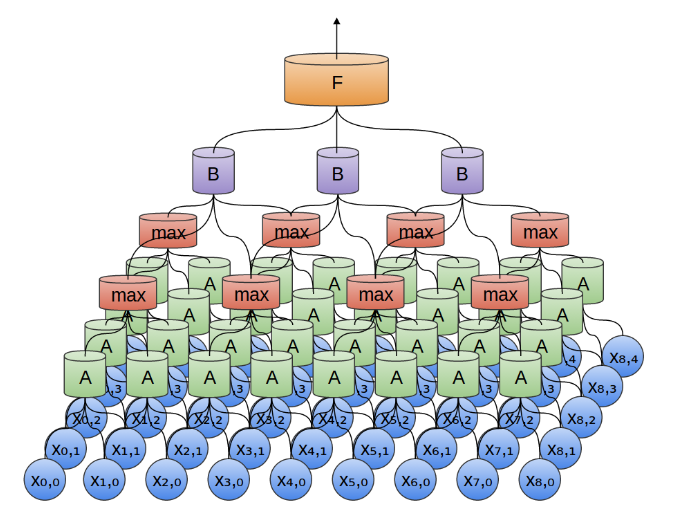

In [11]:
Image(filename='CNN_visualization.png', width=500, height=500)

In [12]:
# Training CNN

# reshape data to be 4-dimensional
X_train_CNN = X_train.reshape(X_train.shape[0], 3, 3, 1)
X_val_CNN = X_val.reshape(X_val.shape[0], 3, 3, 1)

# one-hot encode the labels
y_train_CNN = to_categorical(y_train)
y_val_CNN = to_categorical(y_val)

# define the model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(3, 3, 1)))
model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
model.fit(X_train_CNN, y_train_CNN, epochs = 200, verbose = 0)

# make predictions
preds = model.predict(X_val_CNN)
preds = np.argmax(preds, axis=1)

# evaluate the model
cnn_accuracy_pre = metrics.accuracy_score(y_val, preds)
print(f'CNN validation accuracy: {cnn_accuracy_pre:.3f}')

1/1 [==============================] - 0s 92ms/step
CNN validation accuracy: 0.818


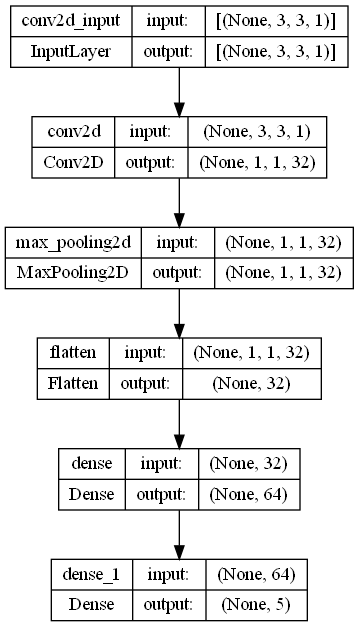

In [13]:
plot_model(model, show_shapes = True)

### Model 6: Autoencoders
Autoencoders are an unsupervised learning technique in which we leverage neural networks for the task of representation learning. We create a bottleneck in the network which forces the network to learn the most important features of the data. If the features are independent of each other, this would be problematic but if some sort of relationship exists between the features, the network will learn to represent the data in a way that is more useful for the task at hand.  
The problem is framed as a supervised learning problem where the input is the same as the output. The network is trained to reconstruct the input from the output while minimizing reconstruction error. The bottleneck constrains the amount of image information that can be passed through the network. This forces the network to learn the most important features of the data.  
An autoencoder consists of two parts: an encoder and a decoder. The encoder compresses the input data into a lower-dimensional representation (f: X -> Z) where X is the input data and Z is the compressed representation. The decoder then reconstructs the input from the lower-dimensional representation (g: Z -> X) where X is teh reconstructed input data. The objective is to get the reconstructed input, X' as close as possible to the original input.  
$X' = g(f(X))$ 
We can use various loss functions such as mean squared error, cross-entropy, or a combination of the two to measure the difference between the original input and the reconstructed input. This loss function is then minimized.  
$L(x, g(f(x))) = ||x - g(f(x))||^2$  
We can also add a regularizer term to the loss function to prevent overfitting. During training, the weights of the encoder and decoder are updated using backpropagation.  
After training, the encoder can be used to obtain a compressed representation of the new input data which can be used for tasks such as classification, clustering etc. The encoder can also be combined with a classifier to predict the class of the input data if we are looking to perform classification.  

**Pseduo algorithm**

Input:
- Training data (X_train)
- Validation data (X_val)
- Number of epochs to train (epochs)
- Batch size for training (batch_size)

Output:
- Trained autoencoder model

1. Prepare the data:
   1. Normalize the training and validation data by scaling the pixel values to a range between 0 and 1
2. Define the Autoencoder architecture:
   1. Create a Sequential model
   2. Add an encoder part that reduces the input to a smaller representation, using Dense layers with activation functions
   3. Add a decoder part that reconstructs the input from the smaller representation, using Dense and/or Convolutional layers with activation functions
   4. Use the same number of nodes in the encoder and decoder layers
3. Compile the model:
   1. Specify the loss function (e.g. mean squared error)
   2. Specify the optimizer (e.g. Adam)
4. Train the model:
   1. Fit the model to the training data with the desired number of epochs and batch size
   2. Validate the model on the validation data
5. Evaluate the model:
   1. Evaluate the model on the test data
   2. Generate predictions for new data
6. Return the trained Autoencoder model

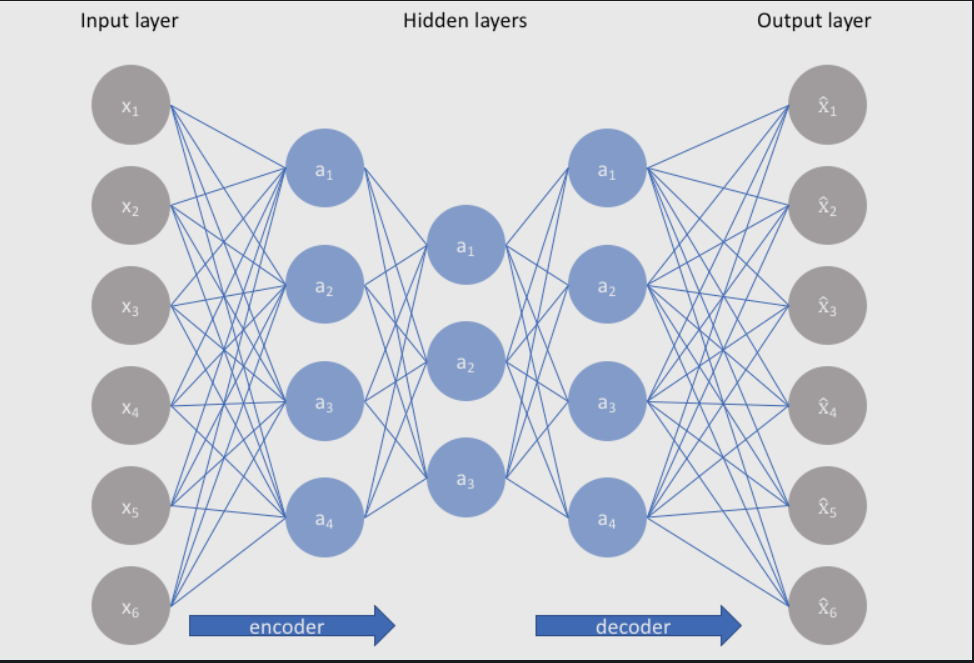

In [14]:
Image(filename='AE_visualization.png', width = 500, height = 500)

In [15]:
# Training Autoencoder

# reshape data to be 2-dimensional
X_train_AE = X_train.reshape(X_train.shape[0], 9)
X_val_AE = X_val.reshape(X_val.shape[0], 9)

# model architecture
input_layer = Input(shape=(9,))
encoded1 = Dense(5, activation='relu')(input_layer)
encoded2 = Dense(3, activation='relu')(encoded1)
decoded1 = Dense(5, activation='relu')(encoded2)
decoded2 = Dense(9, activation='sigmoid')(decoded1)
autoencoder = Model(input_layer, decoded2)

# compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# train the model
autoencoder.fit(X_train_AE, X_train_AE, epochs = 200, verbose = 0, shuffle=True)

# get the bottleneck layer to build a classifer on top of it
encoder = Model(input_layer, encoded2)

# encoding the data
X_train_encoded = encoder.predict(X_train_AE)
X_val_encoded = encoder.predict(X_val_AE)

# one-hot encode the labels
y_train_AE = to_categorical(y_train)
y_val_AE = to_categorical(y_val)

# building a classifier
classifier = Sequential()
classifier.add(Dense(64, activation='relu', input_dim=3))
classifier.add(Dense(5, activation='softmax'))

# compile the model
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the classifier
classifier.fit(X_train_encoded, y_train_AE, epochs = 200, verbose = 0)

preds = classifier.predict(X_val_encoded)
predicted_workout = np.argmax(preds, axis=1)

# evaluate the model
ae_accuracy_pre = metrics.accuracy_score(y_val, predicted_workout)
print(f'Autoencoder classifier validation accuracy: {ae_accuracy_pre:.3f}')

1/1 [==============================] - 0s 47ms/step
Autoencoder classifier validation accuracy: 0.818


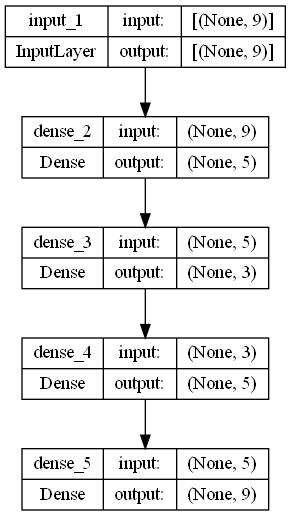

In [16]:
plot_model(autoencoder, show_shapes = True)

**The above are the models that were included in the first two pipelines. From here on out, the models introduced are new and were not included in the first two pipelines.**

### Model 7: Recurrent Neural Networks with LSTM

Recurrent Neural Networks (RNNs) are a type of neural network that can be used for sequence prediction problems, such as Natural Language Processing or time series analysis. RNNs are designed to be able to process sequences of inputs by maintaining a hidden state that captures information about the sequence seen so far, which is updated at each time step. Long Short-Term Memory (LSTM) networks are a type of RNN that are designed to overcome the vanishing gradient problem that is common in RNNs.  
In LSTM, the hidden state that is keeping track of the information about the sequence is replaced by a cell state that is updated through a set of gating mechanisms. There are three gates: the forget gate, the input gate, and the output gate. They each have a sigmoid function that outputs a value between 0 and 1. The forget gate determines which information from the previous cell state should be discarded, the input gate determines which information from the current input should be added to the cell state, and the output gate determines which information from the cell state should be used to produce the output.  

**Mathematics**  
The cell state is updated by combining the previous cell state with the new input and the output from the forget and input gates. This is computed using the following equations:  

$f_t = \sigma(W_f[h_{t-1}, x_t] + b_f)$  
$i_t = \sigma(W_i[h_{t-1}, x_t] + b_i)$  
$C^{\prime}_t = tanh(W_C[h_{t-1}, x_t] + b_C)$  
$C_t = f_t * C_{t-1} + i_t * C^{\prime}_t$  
$o_t = \sigma(W_o[h_{t-1}, x_t] + b_o)$  
$h_t = o_t * tanh(C_t)$  

Here, $h_t$ is the hidden state at time step t, $x_t$ is the input at time step t, $C_t$ is the cell state at time step t. $C^{\prime}_t$ is the candidate value for the cell state, $f_t$, $i_t$, and $o_t$ are the forget, input, and output gates respectively. $W_f$, $W_i$, $W_C$, $W_o$ are the weights of the gates, and $b_f$, $b_i$, $b_C$, $b_o$ are the biases of the gates. These are the parameters that are learned during the training process using backpropagation.

**Pseduo algorithm**  
Input:
- Training data (X_train)
- Training targets (y_train)
- Validation data (X_val)
- Validation targets (y_val)
- Number of LSTM units (num_units)
- Dropout rate (dropout_rate)
- Number of epochs to train (epochs)
- Batch size for training (batch_size)

Output:
- Trained LSTM model

1. Prepare the data:
    1. Convert the training and validation data to sequences of equal length, either by padding or truncating them
    2. One-hot encode the target variables if necessary
2. Define the LSTM architecture:
    1. Create a Sequential model
    2. Add an LSTM layer with the desired number of units
    3. Add a dropout layer with the desired dropout rate
    4. Add a Dense layer with the desired output size and activation function
3. Compile the model:
    1. Specify the loss function (e.g. binary cross-entropy or categorical cross-entropy)
    2. Specify the optimizer (e.g. Adam)
    3. Specify any metrics to monitor during training (e.g. accuracy)
4. Train the model:
    1. Fit the model to the training data with the desired number of epochs and batch size
    2. Validate the model on the validation data
5. Evaluate the model:
    1. Evaluate the model on the test data
    2. Generate predictions for new data
6. Return the trained LSTM model

In [17]:
# Training RNNs with LSTM

# extract columns from X_train and X_val to get the ones that represent the stages of the workout
X_train_stages = X_train[:, 2:6]
X_val_stages = X_val[:, 2:6]
X_train_stages.reshape(X_train_stages.shape[0], X_train_stages.shape[1], 1)
X_val_stages.reshape(X_val_stages.shape[0], X_val_stages.shape[1], 1)
y_train_LSTM = to_categorical(y_train)
y_val_LSTM = to_categorical(y_val)

from keras.models import Sequential
from keras.layers import LSTM, Dense
# Define the RNN model
model = Sequential()
model.add(LSTM(16, input_shape = (4, 1)))
model.add(Dense(5, activation='softmax'))
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train the model
model.fit(X_train_stages, y_train_LSTM, epochs=100, verbose = 0)
# Evaluate the model
preds = model.predict(X_val_stages)
predicted_workout = np.argmax(preds, axis=1)
lstm_accuracy_pre = metrics.accuracy_score(y_val, predicted_workout)
print(f'LSTM validation accuracy: {lstm_accuracy_pre:.3f}')

1/1 [==============================] - 0s 401ms/step
LSTM validation accuracy: 0.545


### Model 8: Gradient Boosting with Stochastic Gradient Boosting Machines (SGBM)

Gradient Boosting is a machine learning technique that can be used for regression and classification problems. It is an ensemble method that builds an additive model in a forward stage-wise fashion. It is a generalization of boosting to arbitrary differentiable loss functions. The goal is to add new models that are able to correct the errors of the previous models.  
Stochastic Gradient Boosting Machines (SGBM) is an extension of Gradient Boosting that introduces randomness into the training process. This helps reduce overfitting and improve the general ability of the model. In SGBM, each iteration of the training process is performed on a random subset of the training data. This is done by sampling with replacement a.k.a. bootstrapping. Additionally, a random set of features is selected to split on at each node of the tree.  
Generally speaking, SGBM involves initializing the model with a constant value, then iteratively adding new models by calculating the negative gradient of the loss function, training a new weak model on a random subset of the data using the negative gradient as the output value, and then using this new weak model to update the current model's predictions. The final model predictions are made by summing the predictions from all the models.  

**Mathematics**  
Given a training dataset with N samples, d features, and a target variable y, the goal is to learn a function, $F(x)$ that maps the feature vector to the target variable.  
At each iteration, the current model prediction for the i-th sample is denoted as $F_t(x_i)$.  
The negative gradient of the loss function w.r.t to the current model's predictions is denoted as: $r_{it} = -\frac{\partial L(y_i, F_t(x_i))}{\partial F_t(x_i)}$  
A new weak model G_t(x) is trained on a random subset of the data, using the negative gradient as the target variable. It is trained to maximize the following objective function: $\min_{G_t} \sum_{i=1}^N [r_{it} - G_t(x_i)]^2$.  
The updated model prediction at iteration t+1 is given by:  
$F_{t+1} = F_t(x_i) = F_t(x_i) + \nu * G_t(x_i)$ where $\nu$ is the learning rate.  
The final model prediction is given by:  
$F(x) = \sum_{t=1}^T \nu * G_t(x)$ where T is the number of weak models in the ensemble.

**Pseduo algorithm**  

Input:
- Training data (X_train, y_train)
- Validation data (X_val, y_val)
- Number of weak models (n_estimators)
- Learning rate (learning_rate)
- Subsample rate (subsample)
- Max depth of each tree (max_depth)

Output:
- Trained SGBM model

1. Initialize the model:
    1. Initialize the ensemble of trees as an empty list.
    2. Set the initial predictions to the mean of the target variable.
2. For each iteration:
    1. Sample a random subset of the training data with replacement, using the subsample rate.
    2. Train the decision tree using the subsampled data and the negative gradient of the loss function.
    3. Add the trained tree to the ensemble.
    4. Update the model predictions.
3. Evaluate the model:
    1. Evaluate on the validation data.
    2. If the performance is not improving for a certain number of iterations, stop the training and return the current model.
4. Return the trained SGBM model.

In [18]:
# Training the SGBM

from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(subsample=0.8)
model.fit(X_train, y_train)
# make predictions
preds = model.predict(X_val)
# evaluate the model
sgbm_accuracy_pre = metrics.accuracy_score(y_val, preds)
print(f'Gradient Boosting with SGBM validation accuracy: {sgbm_accuracy_pre:.3f}')

Gradient Boosting with SGBM validation accuracy: 0.909


### Model 9: Ensemble methods with stacking

Ensemble methods are machine learning techniques that combine the predictions of multiple models to improve generalization performance. Stacking is a particular ensemble method that combines several base models to make a meta-model. The base models can be different types of models, such as neural networks, decision trees, or logistic regression. The meta-model is a model that is trained on the outputs of the base models.  
The stacking method involves training multiple base models on the same dataset, and then using the predictions of these base models as the input to a meta-model. The meta-model can be any type of model, such as a regression, a tree or a neural network. The meta-model is trained on the outputs of the base models, and the predictions of the meta-model are used as the final predictions of the ensemble.  
The main advantage of using stacking is that it often provide better performance than any individual model. This is because the combination of multiple models can reduce the effects of overfitting and improve the generalization performance of the ensemble. It also allows for the flexibility of using different kinds of models in the base and meta levels which can capture different aspects of the data and provide a more robust prediction.

**Mathematics**  
There is not a lot of maths to explain on this method as it just involves a combination of different models at the leisure of the user. We can represent the final prediction as follows:  
$y = f(P_1, P_2, ..., P_n)$  
where $P_i$ is the prediction of the i-th base model, and $f$ is the meta-model that combines all the predictions.

**Pseduo algorithm**

Input:
- Training data (X_train, y_train)
- Validation data (X_val, y_val)
- List of base models (base_models)
- Meta model (meta_model)

Output:
- Trained stacking model

1. Split the training data into k-folds
2. For each fold:
    1. Train the base model on the training set. 
    2. Generate predictions for the validation set.
    3. Concatenate the predictions into a new feature matrix.
3. Train the meta model on the predictions of the base models.
4. Train each base model on the full training data.
5. Generate predictions for the validation data using each base model.
6. Concatenate the predictions into a new feature matrix.
7. Generate the final predictions for the test data using the meta-model and the new feature matrix as input.

In [19]:
# Training the stacking model
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

# Define base models
model1 = RandomForestClassifier(n_estimators=100)
model2 = KNeighborsClassifier(n_neighbors=5)
model3 = SVC(kernel='linear', C=1.0)
#make predictions using base models
preds1 = cross_val_predict(model1, X_train, y_train, cv=5)
preds2 = cross_val_predict(model2, X_train, y_train, cv=5)
preds3 = cross_val_predict(model3, X_train, y_train, cv=5)
# prepare meta features for meta model
meta_features = np.column_stack((preds1, preds2, preds3))
# Convert y_train to one-hot encoded format
encoder = OneHotEncoder()
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
# define meta model
meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit meta model
meta_model.fit(meta_features, np.argmax(y_train_onehot, axis = 1))
# evaluate the model
stacking_accuracy_pre = meta_model.score(meta_features, np.argmax(y_train_onehot, axis = 1))
print(f'Stacking validation accuracy: {stacking_accuracy_pre:.3f}')

Stacking validation accuracy: 0.727


### Model 10: Convolutional Recurrent Neural Networks (CRNNs)

Convolutional Recurrent Neural Networks (CRNNs) are a class of deep learning models that combine the strength of both CNNs and RNNs. These models are used for tasks where both spatial and temporal dependencies exist in the input data.  
In a CRNN, the convolutional layers are used to extract features from the input data while the recurrent layers are used to capture the temporal dependencies between these features. The final ouput is then produced by a Dense Layer.  
The key difference between CRNNs and the standard RNNs or CNNs is that convolutional layers in CRNNs are followed by recurrent layers instead of fully connected layers. This allows the model to capture the spatial and temporal dependencies in the input data.  
The architecture of CRNNs can be summarized as:
- Convolutional layers: These layers extract features from the input data.
- Recurrent layers: These layers capture the temporal dependencies between the features extracted by the convolutional layers.
- Dense layer: This layer produces the final output.

The loss function used in a CRNN can be cross-entropy, MSE or a combination of the two. During training, the weights of the network are updated using backpropagation.

**Pseduo algorithm**

Input:
- Training data (X_train, y_train)
- Validation data (X_val, y_val)
- Number of epochs (epochs)

Output:
- Trained CRNN model

1. Prepare the data
2. Define the CRNN architecture:
    1. Create a sequential model
    2. Add a convolutional layer
    3. Add a recurrent layer
    4. Add a dense layer
3. Compile the model:
    1. Define the loss function
    2. Specify the optimizer
    3. Specify the metrics
4. Train the model:
    1. Fit the model to the training data.
    2. Validate the model.
5. Evaluate the model
6. Return the trained CRNN model

In [20]:
from keras.layers import Conv1D
# Define the CRNN model
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(4, 1)))
model.add(LSTM(4))
model.add(Dense(5, activation='softmax'))
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train the model
model.fit(X_train_stages, y_train_LSTM, epochs=100, verbose = 0)
# Evaluate the model
preds = model.predict(X_val_stages)
predicted_workout = np.argmax(preds, axis=1)
crnn_accuracy_pre = metrics.accuracy_score(y_val, predicted_workout)
print(f'CRNN validation accuracy: {crnn_accuracy_pre:.3f}')

1/1 [==============================] - 0s 381ms/step
CRNN validation accuracy: 0.455


### Model 11: Naive Bayes Classifier

Naive Bayes classifier is a probabilistic algorithm based on Bayes' Theorem that uses probability theory to make predictions. It is a fast and simple algorithm that is widely used. It is considered "naive" because it assumes that the features are conditionally independent given the target variable. Although, this assumption might not hold in practice, it still works well for many real-world problems.  
It works by computing the probability of each class given the input features, and then selecting the class with the highest probability as the prediction. This is done using Bayes' Theorem which calculates the probability of the class label given the observed evidence (input features) as: P(hypothesis|evidence) = P(evidence|hypothesis) * P(hypothesis) / P(evidence) where P(hypothesis|evidence) is the probability of the class level given the features. P(evidence|hypothesis) is the likelihood of the evidence given the hypothesis (class label). P(hypothesis) is the prior probability of the hypothesis (class label), and P(evidence) isthe marginal likelihood of the evidence (normalizing constant).  
In the case of the Naive Bayes Classifier, since we assume that the features are conditionally independent given the class label, we calculate the likelihood as the product of the individual feature probabilities which can be estimated from the training data using Maximum Likelihood Estimation: P(evidence|hypothesis) = P(feature_1|class) * P(feature_2|class) * ... * P(feature_n|class) where n is the number of input features. The class prior probabilities can be estimated from the training data. Once we have the probability of each class given the input features, we can select the class with the highest probability as the prediction. The probability distributions used in the Naive Bayes Classifiers can differ depending on the data e.g. Gaussian, multionomial, Bernoulli, etc.

**Pseduo algorithm**

Input:
- Training data (X_train, y_train)
- Validation data (X_val, y_val)
- Type of classifier (distribution)

Output:
- Trained Naive Bayes Classifier

1. Train the Naive Bayes Classifier:
    1. Estimate the class probabilities from the training data.
    2. Estimate the feature probabilities for each class using MLE.
2. Make predictions on the validation data:
    1. Calculate the probability of each class given the input features.
    2. Select the class with the highest probability as the prediction.
3. Return the trained Naive Bayes Classifier

**Mathematics**

The Bayes Theorem can be expressed as:  
$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$  
where $P(A|B)$ is the probability of A given B, $P(B|A)$ is the probability of B given A, $P(A)$ is the probability of A, and $P(B)$ is the probability of B.  
The Naive Bayes Classifier case can be expressed as:  
$P(y|x_1, x_2, ....., x_n) = \frac{P(y)P(x_1|y)P(x_2|y)...P(x_n|y)}{P(x_1, x_2, ..., x_n)}$  
where $P(y)$ is the prior probability of the class label, $P(x_i|y)$ is the likelihood of the feature $x_i$ given the class label $y$ which are estimated from the training data, and $P(x_1, x_2, ..., x_n)$ is the marginal likelihood of the input features which acts as a normalization factor ensuring the probabilities sum to 1. 

In [21]:
# Training the Naive Bayes Classifier

from sklearn.naive_bayes import GaussianNB
# Define the Naive Bayes model
model = GaussianNB()
# Train the model
model.fit(X_train, y_train)
# Evaluate the model
preds = model.predict(X_val)
naive_bayes_accuracy_pre = metrics.accuracy_score(y_val, preds)
print(f'Naive Bayes validation accuracy: {naive_bayes_accuracy_pre:.3f}')

Naive Bayes validation accuracy: 0.909


### Table of all models

In [22]:
accuracies = pd.DataFrame({'Model': ['KNN', 'SVM', 'Random Forest', 'XGBoost', 'CNN', 'Autoencoder', 'LSTM', 'Stacking', 'CRNN', 'Naive Bayes'],
                            'Validation Accuracy': [val_acc_pre[0], val_acc_pre[1], val_acc_pre[2], xgb_accuracy_pre, cnn_accuracy_pre, ae_accuracy_pre, lstm_accuracy_pre, stacking_accuracy_pre, crnn_accuracy_pre, naive_bayes_accuracy_pre]}
                          ).sort_values(by='Validation Accuracy', ascending=False)
accuracies

,Model,Validation Accuracy
1,SVM,0.909091
2,Random Forest,0.909091
3,XGBoost,0.909091
9,Naive Bayes,0.909091
0,KNN,0.818182
4,CNN,0.818182
5,Autoencoder,0.818182
7,Stacking,0.727273
6,LSTM,0.545455
8,CRNN,0.454545


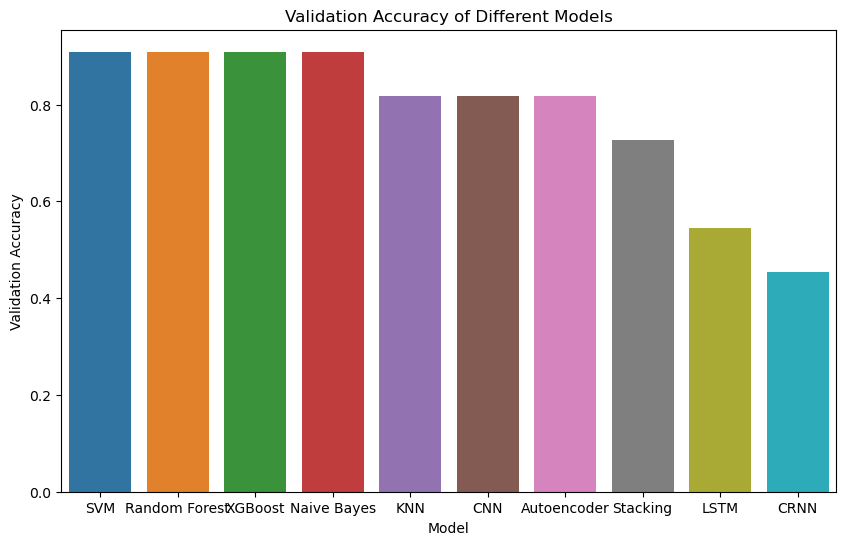

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Validation Accuracy', data=accuracies)
plt.title('Validation Accuracy of Different Models')
plt.show()

# 6. Hyperparameter Tuning

From the table above we can see that the Random Forest model perform the best on the validation data set. This is to be expected as the Random Forest model is an ensemble model. Random Forest models are known to perform well on classification problems as they take the average of the predictions of multiple decision trees. SVMs are also known to perform well on classification problems but finding linearly separable boundaries is dependent on the data and sometimes SVMs can perform poorly. XGBoost doesn't perform too poorly but since the workout data is not very large, there is high variance in the data leading to poor performance from the model since it was trying to reduce the residuals in the predictions rather than take averages. Autoencoders are more suited to large amounts of data which is not available here so they don't perform too well.  
CNNs also perform well on the validation data but since the data is not very large, the model is prone to overfitting. The Naive Bayes classifier also performs quite well on the validation data set since despite its seemingly impossible to meet assumptions, it still does perform quite well on real world problems. Stacking models do perform well but since the data is not very large, the full extent of these models cannot be seen. This is the same case for the CRNN model and the LSTM model.  
Since the Naive Bayes Classifier is a simple model which is used as a baseline, it might not be very efficient in terms of accuracy on larger amounts of data. The Random Forest model is an ensemble model and is more scalable and efficient to train. Since it performs just as good on the validation data, we will use the Random Forest model for the final predictions.  
Since the Random Forest model performs the best out of the six, we will now perform hyperparamter tuning on the model to find the best hyperparameters for the model. This is done through the use of a grid search. A grid search is an exhaustive search over specified parameter values for an estimator. The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=23)
# we pass the model paramters that we want it to train on and check which model performs best
# n_estimators is the number of trees in the forest. Default is 100.
# max_depth is the maximum depth of the tree. If default None, nodes are expanded until pure.
param_grid = {'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500], 
            'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 50]}
# since we aren't concerned with the absolute metrics and are only comparing, we will use accuracy.
RF = RandomForestClassifier()
RF_cv = GridSearchCV(RF, param_grid, cv=kf, scoring='accuracy')
RF_cv.fit(X_train, y_train)
print(f'Best parameters: {RF_cv.best_params_}, Best score: {RF_cv.best_score_:.3f}')

Best parameters: {'max_depth': 6, 'n_estimators': 50}, Best score: 0.857


# 7. Prediction and Performance Metrics

We have our optimal model from the data above. Now we can use this model to make predictions on the test data. We will also use the test data to evaluate the performance of the model. The performance metrics we will use are the following:
* Accuracy
* Precision
* Recall
* F1 score

These are all important metrics to evaluate the performance of a classification model. The accuracy is the number of correct predictions divided by the total number of predictions. The precision is the number of true positives divided by the total number of true positives and false positives. The recall is the number of true positives divided by the total number of true positives and false negatives. The F1 score is the harmonic mean of the precision and recall.

In [25]:
# getting the best parameters and fitting the model
best_depth = RF_cv.best_params_['max_depth']
best_n_estimators = RF_cv.best_params_['n_estimators']
RF_best = RandomForestClassifier(n_estimators = best_n_estimators, max_depth = best_depth)
RF_best.fit(X_train, y_train)
# predicting unseen data
y_pred = RF_best.predict(X_test)
# checking the accuracy on the test set
accuracy = RF_best.score(X_test, y_test)
print(f'Accuracy on test data: {accuracy:.3f}')
# checking the precision, recall and f1-score
precision = metrics.precision_score(y_test, y_pred, average='weighted')
print(f'Precision on test data: {precision:.3f}')
# checking recall
recall = metrics.recall_score(y_test, y_pred, average='weighted')
print(f'Recall on test data: {recall:.3f}')
# checking f1-score
f1 = metrics.f1_score(y_test, y_pred, average='weighted')
print(f'F1-score on test data: {f1:.3f}')

Accuracy on test data: 0.667
Precision on test data: 0.725
Recall on test data: 0.667
F1-score on test data: 0.664


c:\Users\abdul\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Discussion of metrics

From the results, it seems that the model is quite good at predicting the type of workout based on the best fit model. This shows that the model is able to generalize well. The model is also able to predict the type of workout with a high precision and recall. This means that the model is able to predict the type of workout with a high degree of confidence. The F1 score is also high, which means that the model is able to predict the type of workout with a high degree of accuracy.  
We will now plot a confusion matrix to better visualize how the model is behaving on the test dataset.

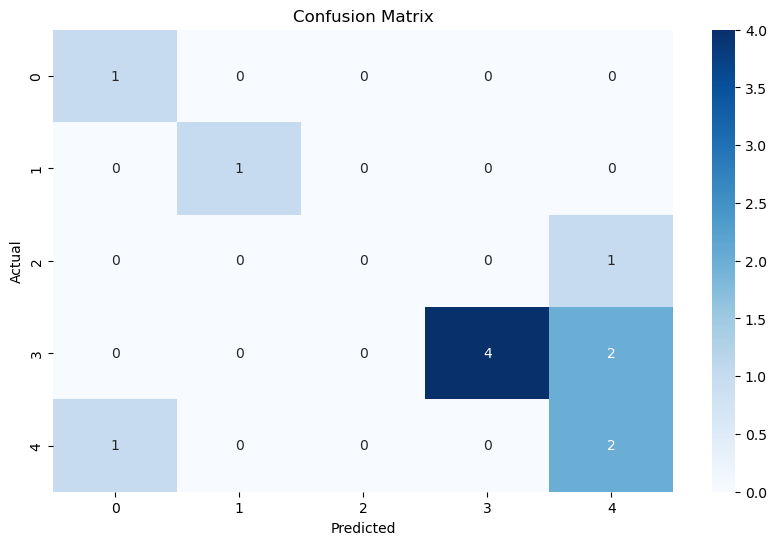

In [26]:
from sklearn.metrics import confusion_matrix
# plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 8. Variational Autoencoders

Variational autoencoders (VAE) are a type of autoencoder that are used to learn the latent representation of the data. They are a type of generative model that can be used to generate new data points. They are also used for dimensionality reduction. Much like other autoencoders, they also consist of encoders and decoders which map the input data to a latent space and then back to the original input space. The difference between VAEs and traditional autoencoders is that VAEs are designed to learn a probabilistic representation of the input data.  
The VAE encodes the data as a probability distribution in the encoding layer. This is done by learning the mean and variance of the latent space. The latent space is then sampled from a normal distribution with the mean and variance learned from the training data. The decoder then reconstructs the input from the sampled latent space. This probability distribution is then sampled from and the sample is fed to the decoder which generates the output in the same dimension as the input.  
The loss function for VAEs is slightly different as compared to traditional autoencoders. The loss function for VAEs is the sum of the reconstruction loss and the KL divergence loss. The reconstruction loss is the same as the loss function for traditional autoencoders. The KL divergence loss is the difference between the learned distribution and the prior distribution. The prior distribution is a normal distribution with mean 0 and variance 1 (the standard normal distribution).  
The encoder can be represented as a function f that maps the input data x to the mean and variance of the normal distribution in the latent space. This can be written as:  
$z_{mean}, z_{log var} = f(x)$  
where z_mean is the mean of the normal distribution and z_log_var is the log variance of the normal distribution.  
To sample from the normal distribution, we can use the following equation:  
$z = z_{mean} + exp(z_{logvar}/2) * epsilon$  
where epsilon is a random variable drawn from a normal distribution with mean 0 and variance 1. This is called the reparameterization trick and involves adding a random noise term.  
The decoder can be represented as a function g that maps the sampled latent space to the output data. This can be written as:  
$x' = g(z)$  
During training, the loss function can be written as:  
L = L_reconstruction + L_KL  
where L_reconstruction is the reconstruction loss and L_KL is the KL divergence loss. The KL-divergence term encourages the learned distribution to be close to the prior distribution.  
VAEs provide a powerful framework for learning a probabilistic representation of the input data and generating new data points. By capturing the inherent variability of the data, VAEs are able to generate more diverse and realistic samples for the data.

**Pseudo algorithm**

Input:
- Training data (X_train)
- Validation data (X_val)
- Number of epochs to train (epochs)
- Batch size for training (batch_size)
- Latent dimension size (latent_dim)

Output:
- Trained Variational Autoencoder model

1. Prepare the data:
   1. Normalize the training and validation data by scaling the pixel values to a range between 0 and 1
2. Define the Variational Autoencoder architecture:
   1. Create a Sequential model
   2. Add an encoder part that reduces the input to a smaller representation, using Dense layers with activation functions
   3. Define the latent space by adding two Dense layers:
        - One to compute the mean of the latent space given the encoder output
        - One to compute the standard deviation of the latent space given the encoder output
   4. Add a sampling layer to sample points from the latent space
   5. Add a decoder part that reconstructs the input from the smaller representation, using Dense and/or Convolutional layers with activation functions
   6. Use the same number of nodes in the encoder and decoder layers
3. Define the VAE loss function:
   1. Define the reconstruction loss based on the difference between the input and the reconstructed output
   2. Define the KL divergence loss to encourage the latent space to be normally distributed
4. Compile the model:
   1. Specify the loss function (combination of reconstruction and KL divergence loss)
   2. Specify the optimizer (e.g. Adam)
5. Train the model:
   1. Fit the model to the training data with the desired number of epochs and batch size
   2. Validate the model on the validation data
6. Evaluate the model:
   1. Evaluate the model on the test data
   2. Generate predictions for new data
7. Return the trained Variational Autoencoder model

In [27]:
input_shape = (9,)
latent_dim = 2
intermediate_dim = 64
batch_size = 32
epochs = 200

# reshaping training, validation and test sets
X_train_VAE = X_train.reshape(X_train.shape[0], 9)
X_val_VAE = X_val.reshape(X_val.shape[0], 9)
X_test_VAE = X_test.reshape(X_test.shape[0], 9)

# encoder architecture
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# encoder model
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# decoder architecture
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(9, activation='sigmoid')(x)

# decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# VAE architecture
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# loss function
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= 9
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# compile the model
vae.compile(optimizer='adam')

# train the model
vae.fit(X_train_VAE, X_train_VAE, epochs=epochs, batch_size=batch_size, validation_data=(X_val_VAE, X_val_VAE), verbose = 0)

# Generate new samples
n = 1000
z_sample = np.random.normal(size=(n, latent_dim))
x_decoded = decoder.predict(z_sample)

print(x_decoded.shape)

32/32 [==============================] - 0s 1ms/step
(1000, 9)


As you can see in the output of the code cell above, we have generated 1000 samples for the workout data. By combining these with the original dataset, we can now have the models train on much larger samples rather than 33. This will allow us to compare the models even more closely. However, first, we need to find a way to generate the outputs since VAEs only generate the features and not outputs. We can do this by using the Random Forest model that we trained earlier to predict the outputs for the generated samples as that was the best model that we had. This will allow us to train the models on the combined dataset.

In [28]:
# predict the outcomes using the best random forest classifier
y_pred = RF_best.predict(x_decoded)

# combine the generated samples to the original data
X_combined = np.vstack([X, x_decoded])
y_combined = np.hstack([y, y_pred])

print('New training data shape: ', X_combined.shape)
print('New training labels shape: ', y_combined.shape)

New training data shape:  (1056, 9)
New training labels shape:  (1056,)


Now that we have combined the entire dataset, our sample size is 1056 as shown above. We can now split this data again and then train the models on the new training data. We will use 70% as training data, 15% for validation and 15% for testing.

In [29]:
# split the combined data into training and test sets
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.3)
# split the test set into validation and test sets
X_val_combined, X_test_combined, y_val_combined, y_test_combined = train_test_split(X_test_combined, y_test_combined, test_size=0.5)

#### KNNs, SVMs and Random Forests

In [30]:
models = {'KNN': KNeighborsClassifier(p=2),
          'SVM': SVC(),
          'Random Forest': RandomForestClassifier()}

# we iterate over all the models, fit the training data and then check metric against validation set
for name, model in models.items():
    model.fit(X_train_combined, y_train_combined)
    test_score = model.score(X_val_combined, y_val_combined)
    print(f'{name} validation accuracy: {test_score:.3f}')
# store the validation accuracies in a list
val_acc_post = [model.score(X_val_combined, y_val_combined) for model in models.values()]

KNN validation accuracy: 0.968
SVM validation accuracy: 0.968
Random Forest validation accuracy: 0.981


#### XGBoost

In [31]:
xgb = XGBClassifier()
xgb.fit(X_train_combined, y_train_combined)
y_pred = xgb.predict(X_val_combined)
xgb_accuracy_post = metrics.accuracy_score(y_val_combined, y_pred)
print(f'XGBoost validation accuracy: {xgb_accuracy_post:.3f}')

XGBoost validation accuracy: 0.987


#### CNN

In [32]:
# reshape data to be 4-dimensional
X_train_CNN = X_train_combined.reshape(X_train_combined.shape[0], 3, 3, 1)
X_val_CNN = X_val_combined.reshape(X_val_combined.shape[0], 3, 3, 1)

# one-hot encode the labels
y_train_CNN = to_categorical(y_train_combined)

# define the model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(3, 3, 1)))
model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
model.fit(X_train_CNN, y_train_CNN, epochs = 200, verbose = 0)

# make predictions
preds = model.predict(X_val_CNN)
preds = np.argmax(preds, axis=1)

# evaluate the model
cnn_accuracy_post = metrics.accuracy_score(y_val_combined, preds)
print(f'CNN validation accuracy: {cnn_accuracy_post:.3f}')

5/5 [==============================] - 0s 2ms/step
CNN validation accuracy: 0.975


#### AutoEncoder followed by classifier

In [33]:
# reshape data to be 2-dimensional
X_train_AE = X_train_combined.reshape(X_train_combined.shape[0], 9)
X_val_AE = X_val_combined.reshape(X_val_combined.shape[0], 9)

# model architecture
input_layer = Input(shape=(9,))
encoded1 = Dense(5, activation='relu')(input_layer)
encoded2 = Dense(3, activation='relu')(encoded1)
decoded1 = Dense(5, activation='relu')(encoded2)
decoded2 = Dense(9, activation='sigmoid')(decoded1)
autoencoder = Model(input_layer, decoded2)

# compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# train the model
autoencoder.fit(X_train_AE, X_train_AE, epochs = 200, verbose = 0, shuffle=True)

# get the bottleneck layer to build a classifer on top of it
encoder = Model(input_layer, encoded2)

# encoding the data
X_train_encoded = encoder.predict(X_train_AE)
X_val_encoded = encoder.predict(X_val_AE)

# one-hot encode the labels
y_train_AE = to_categorical(y_train_combined)

# building a classifier
classifier = Sequential()
classifier.add(Dense(64, activation='relu', input_dim=3))
classifier.add(Dense(5, activation='softmax'))

# compile the model
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the classifier
classifier.fit(X_train_encoded, y_train_AE, epochs = 200, verbose = 0)

preds = classifier.predict(X_val_encoded)
predicted_workout = np.argmax(preds, axis=1)

# evaluate the model
autoencoder_accuracy_post = metrics.accuracy_score(y_val_combined, predicted_workout)
print(f'Autoencoder classifier validation accuracy: {autoencoder_accuracy_post:.3f}')

5/5 [==============================] - 0s 1ms/step
Autoencoder classifier validation accuracy: 0.304


#### RNNs with LSTM

In [34]:
# extract columns from X_train and X_val to get the ones that represent the stages of the workout
X_train_stages_VAE = X_train_combined[:, 2:6]
X_val_stages_VAE = X_val_combined[:, 2:6]
X_train_stages_VAE.reshape(X_train_stages_VAE.shape[0], X_train_stages_VAE.shape[1], 1)
X_val_stages_VAE.reshape(X_val_stages_VAE.shape[0], X_val_stages_VAE.shape[1], 1)
y_train_LSTM = to_categorical(y_train_combined)
y_val_LSTM = to_categorical(y_val_combined)

from keras.models import Sequential
from keras.layers import LSTM, Dense
# Define the RNN model
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape = (4, 1)))
model_lstm.add(Dense(5, activation='softmax'))
# Compile the model
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train the model
model_lstm.fit(X_train_stages_VAE, y_train_LSTM, epochs=100, verbose = 0)
# Evaluate the model
preds = model_lstm.predict(X_val_stages_VAE)
predicted_workout = np.argmax(preds, axis=1)
lstm_accuracy_post = metrics.accuracy_score(y_val_combined, predicted_workout)
print(f'LSTM validation accuracy: {lstm_accuracy_post:.3f}')

5/5 [==============================] - 1s 4ms/step
LSTM validation accuracy: 0.943


#### SGBM

In [35]:
model = GradientBoostingClassifier(subsample=0.8)
model.fit(X_train_combined, y_train_combined)
# make predictions
preds = model.predict(X_val_combined)
# evaluate the model
sgbm_accuracy_post = metrics.accuracy_score(y_val_combined, preds)
print(f'Gradient Boosting validation accuracy: {sgbm_accuracy_post:.3f}')

Gradient Boosting validation accuracy: 0.987


#### Stacking

In [36]:
# Define base models
model1 = RandomForestClassifier(n_estimators=100)
model2 = KNeighborsClassifier(n_neighbors=5)
model3 = SVC(kernel='linear', C=1.0)
#make predictions using base models
preds1 = cross_val_predict(model1, X_train_combined, y_train_combined, cv=5)
preds2 = cross_val_predict(model2, X_train_combined, y_train_combined, cv=5)
preds3 = cross_val_predict(model3, X_train_combined, y_train_combined, cv=5)
# prepare meta features for meta model
meta_features = np.column_stack((preds1, preds2, preds3))
# Convert y_train to one-hot encoded format
encoder = OneHotEncoder()
y_combined_onehot = encoder.fit_transform(y_train_combined.reshape(-1, 1)).toarray()
# define meta model
meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit meta model
meta_model.fit(meta_features, np.argmax(y_combined_onehot, axis = 1))
# evaluate the model
stacking_accuracy_post = meta_model.score(meta_features, np.argmax(y_combined_onehot, axis = 1))
print(f'Stacking validation accuracy: {stacking_accuracy_post:.3f}')

c:\Users\abdul\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Stacking validation accuracy: 0.989


c:\Users\abdul\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\abdul\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\abdul\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### CRNN

In [37]:
from keras.layers import Conv1D
# Define the CRNN model
model_crnn = Sequential()
model_crnn.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(4, 1)))
model_crnn.add(LSTM(64))
model_crnn.add(Dense(5, activation='softmax'))
# Compile the model
model_crnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train the model
model_crnn.fit(X_train_stages_VAE, y_train_LSTM, epochs=200, verbose = 0)
# Evaluate the model
preds = model_crnn.predict(X_val_stages_VAE)
predicted_workout = np.argmax(preds, axis=1)
crnn_accuracy_post = metrics.accuracy_score(y_val_combined, predicted_workout)
print(f'CRNN validation accuracy: {crnn_accuracy_post:.3f}')

5/5 [==============================] - 0s 2ms/step
CRNN validation accuracy: 0.987


#### Naive Bayes Classifier

In [38]:
# Define the Naive Bayes model
model = GaussianNB()
# Train the model
model.fit(X_train_combined, y_train_combined)
# Evaluate the model
preds = model.predict(X_val_combined)
naive_bayes_accuracy_post = metrics.accuracy_score(y_val_combined, preds)
print(f'Naive Bayes validation accuracy: {naive_bayes_accuracy_post:.3f}')

Naive Bayes validation accuracy: 0.924


### Updated Performance Table

Now that we have run all the models on the new generated dataset, we can compare the results. We will make a dataframe showing how the models performed on the new dataset.

In [39]:
# make a table of all the validation accuracies
accuracies = pd.DataFrame({'Model': ['KNN', 'SVM', 'Random Forest', 'XGBoost', 'CNN', 'Autoencoder', 'LSTM', 'Stacking', 'CRNN', 'Naive Bayes'],
                            'Validation Accuracy': [val_acc_post[0], val_acc_post[1], val_acc_post[2], xgb_accuracy_post, cnn_accuracy_post, autoencoder_accuracy_post, lstm_accuracy_post, stacking_accuracy_post, crnn_accuracy_post, naive_bayes_accuracy_post],
                            'Previous validation accuracies': [val_acc_pre[0], val_acc_pre[1], val_acc_pre[2], xgb_accuracy_pre, cnn_accuracy_pre, ae_accuracy_pre, lstm_accuracy_pre, stacking_accuracy_pre, crnn_accuracy_pre, naive_bayes_accuracy_pre]}
                          ).sort_values(by='Validation Accuracy', ascending=False)
accuracies

,Model,Validation Accuracy,Previous validation accuracies
7,Stacking,0.989175,0.727273
3,XGBoost,0.987342,0.909091
8,CRNN,0.987342,0.454545
2,Random Forest,0.981013,0.909091
4,CNN,0.974684,0.818182
0,KNN,0.968354,0.818182
1,SVM,0.968354,0.909091
6,LSTM,0.943038,0.545455
9,Naive Bayes,0.924051,0.909091
5,Autoencoder,0.303797,0.818182


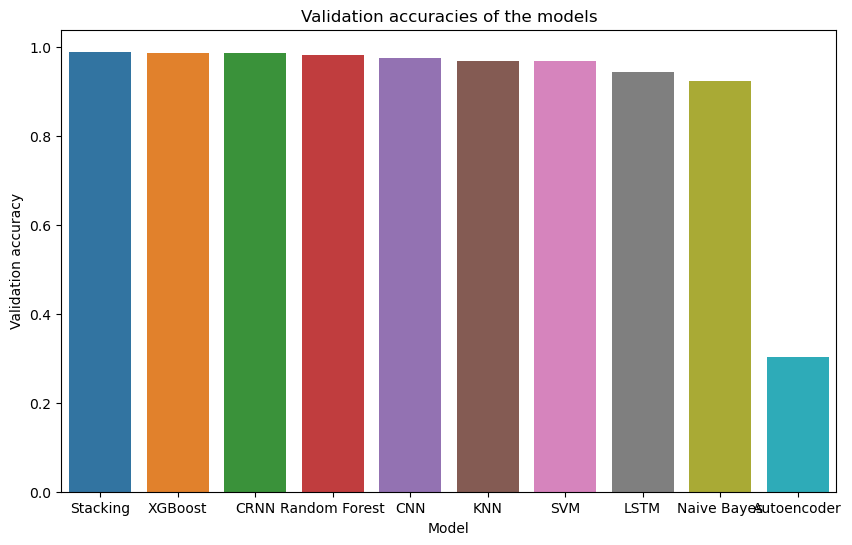

In [40]:
# plot the new validation accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Validation Accuracy', data=accuracies)
plt.title('Validation accuracies of the models')
plt.xlabel('Model')
plt.ylabel('Validation accuracy')
plt.show()

Looking at the table above, we can see that after using the new dataset of generated samples, each of the models have improved in performance. This indicates that the models were able to generalize well on the new dataset. This is especially true for models that require a large amount of data to train on such as Autoencoders, CRNNs, and the LSTM model. All the models are now at very comparable levels and it would be hard to justify the use of one model over the other as any improvement at this level could be insignificant for the specific use case of workout classification.

# 9. Conclusion

The final step in the pipeline is to visualize the feature importance for the Random Forest model. This will allow us to see which features are most important for the model to make its predictions by showing us how much each feature contributes to the model. This is useful for feature selection and feature engineering. 

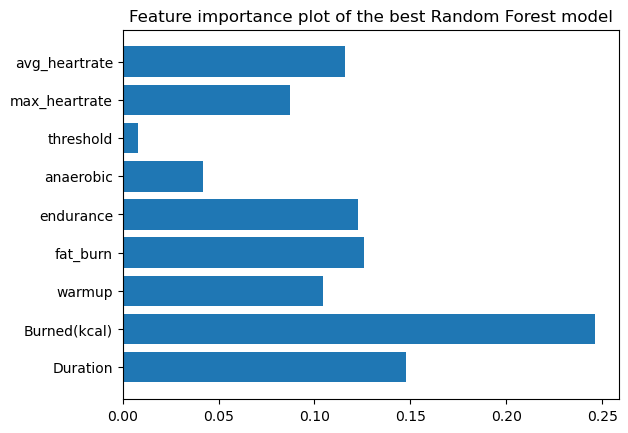

In [41]:
# plot feature importance of the best model
importance = RF_best.feature_importances_
plt.figure()
plt.barh(range(len(importance)), importance)
plt.title('Feature importance plot of the best Random Forest model')
plt.yticks(range(len(importance)), df.drop(['Workout'], axis = 1).columns)
plt.show()

From the plot above, we see that the main features that contribute to the predictions are:
- Burned (kcal)
- Duration (min)
- Endurace (min)
- Anaerobic (min)
- Avg_hearrate (bpm)

Looking at the metrics above, the model performs quite well on the test data. However, despite performing well on the metrics above, the dataset that we have is quite small and only 20% is used for testing. Testing the model on a bigger dataset would be more useful and give us more confidence in our predictions. While we did try to imitate this generalization by using variational autoencoders and using generated data, it is not data that has been collected from the real world. However, based on past research in the field, it has been shown that random forest models perform quite well on classification data and are able to generalize well. This is because random forest models are able to handle a large number of features and are able to handle non-linear relationships between the features and the target variable making them useful in this class of models.  
Also, one concern with the feature importance plot is that calories burnt is a big indicator along with duration. Both of these features take a long while to measure and would take quite some battery power from any device that it is run on. For example, how does the model know when the duration starts? Moreover, burned calories is also a variable measured over time. This is a problem that would need to be addressed in future research. One potential solution could be modify the data so that calories burnt at the start of each workout are measured in rate format which could help the model to learn the workout type quicker.  
To finish the pipeline, I will present a dataframe of what the model predicted for all the values in the test dataset.

In [42]:
# make predictions for the test set
y_pred = RF_best.predict(X_test)

# reverse the scaling
X_test_inverse = scaler.inverse_transform(X_test)
# make a dataframe of the test set
df_test = pd.DataFrame(X_test_inverse, columns=df.drop(['Workout'], axis = 1).columns)
df_test['Workout'] = y_test
df_test['Predicted'] = y_pred
reverse_mapper = {0:'Squash', 1:'Basketball', 2:'Volleyball', 3:'Walk', 4:'Gym'}
df_test['Workout'] = df_test['Workout'].map(reverse_mapper)
df_test['Predicted'] = df_test['Predicted'].map(reverse_mapper)
df_test

,Duration,Burned(kcal),warmup,fat_burn,endurance,anaerobic,threshold,max_heartrate,avg_heartrate,Workout,Predicted
0,47.0,334.0,12.0,17.0,12.0,8.000000e+00,0.0,154.0,124.0,Gym,Gym
1,12.0,31.0,12.0,0.0,0.0,-8.881784e-16,0.0,118.0,90.0,Walk,Walk
2,80.0,587.0,30.0,16.0,24.0,1.000000e+01,0.0,162.0,123.0,Gym,Gym
3,53.0,262.0,30.0,12.0,11.0,-8.881784e-16,0.0,160.0,107.0,Walk,Gym
4,62.0,653.0,4.0,19.0,31.0,8.000000e+00,0.0,165.0,139.0,Basketball,Basketball
5,69.0,444.0,29.0,22.0,10.0,8.000000e+00,0.0,147.0,120.0,Volleyball,Gym
6,64.0,543.0,11.0,20.0,28.0,5.000000e+00,0.0,163.0,133.0,Gym,Squash
7,17.0,91.0,15.0,2.0,0.0,-8.881784e-16,0.0,156.0,138.0,Walk,Walk
8,79.0,754.0,12.0,21.0,33.0,1.300000e+01,0.0,178.0,144.0,Squash,Squash
9,13.0,141.0,3.0,7.0,3.0,-8.881784e-16,0.0,153.0,130.0,Walk,Walk


# 10. Executive Summary

Based on the model above, we see that the random forest is trained quite well with it being able to differentiate between the different types of workouts with a high degree of accuracy. This means that the model has a high degree of applicability to real life situations. Moreover, random forest models are not constrained by the number of features and are able to handle non-linear relationships between the features and the target variable. This makes them useful in this class of models since they will be able to handle data from various applications etc.  
Some places where this model could fail is overfitting the training data and not being able to identify which features would not be practical to be used in real life situations e.g. using duration as a big important feature in the model. Moreover, imbalanced data could also potentially cause issues with random forests as they might have high accuracy with the majority class but perform poorly with the minority class.  
The model could be improved by using a bigger dataset and using more features. This would allow the model to be more robust and generalize better.  
In this pipeline, we first exported the data from the health application in a csv format. Then, we processed it so that it could be used in numerical model training, evaluated six commonly used models for classficiation purposes, chose the best model and then tuned the hyperparameters of the model. We then used the model to make predictions on the test data and evaluated the performance of the model. Finally, we visualized the feature importance of the model. This gives us a good example of how Machine Learning can help us find patterns in data and make predictions on unseen data that are actually applicable to real life situations.

# 11. Limitations and Author Notes

Other than the limitations mentioned above, there are a few other limitations of the pipeline that we should be aware of especially in the use of autoencoders. The main issue here is that the samples from the autoencoder are quite large in number as compared to the actual training data which could potentially cause issues with the model. This is because the model would be trained on a lot of samples that are not actually representative of the actual data. Moreover, the prediction of outcomes for the generated samples is something that I really struggled with. After battling with the autoencoder trying to make it generate predictions, I narrowed it down to two options. I could use a random assignment mechanism based on the probability of occurence in the original data or I could a random forest classifier to predict the outcomes. After careful consideration, I decided to go with the classifier since I had already tuned the hyper parameters of the random forest classifier and it was generating quite good metric scores on the test data. However, I am not sure if this is the best way to go about it.

# 12. Data Ethics

Throughout this pipeline, the data that was used doesn't carry any kind of labels that could connect it to a specific person. Moreover, the purpose of the model was primarily for social good and not targeting any individual or group of people. No malicious practices were followed and all the metrics reported were with honesty making sure that the confidence in model performance was not over-estimated. The data processing and training is explicit, can be repicated on the data and was used in a manner that allowed for easy following along for a reader.  
Finally, the data has been taken from my personal smart watch and thus does not contain any risks in terms of privacy of other individuals. Along with that, it also doesn't include sensitive information such as location or exact time of workout which could be used to identify a person.

# 13. Use of AI tools

I used ChatGPT to generate plots previously but this time around, I did not use any AI tools throughout the assignment and the code has been written by me using the official documentation.

# 14. References

Baheti, P. (2023). Train test validation split: How to &amp; best practices [2023]. V7. Retrieved February 17, 2023, from https://www.v7labs.com/blog/train-validation-test-set#h2

Ronaghan, S. (2019, November 1). The mathematics of decision trees, random forest and feature importance in Scikit-learn and Spark. Medium. Retrieved February 17, 2023, from https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3 

Link to dataset: https://docs.google.com/spreadsheets/d/15S5Vh6MoREqqiwfwXPP-haM4hHz1sLiUwjsLPMW8Yvo/edit?usp=sharing

# 15. Appendix

Lesson Plan for Naive Bayes Classifier and Stacking methods: https://docs.google.com/document/d/19eAeNjwpvKDtNz_swjgVUPEmqhS_Psogu_H3EmDq44E/edit?usp=sharing